# RandomForest Classifier

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, mean_squared_error, confusion_matrix

In [6]:
data = pd.read_csv('./data/data_processed.csv')

data['target'] = data['readmitted'].isin(['<30']).astype(int)

data = data.drop(columns='readmitted')

In [7]:
X = data.drop(columns = 'target')
y = data['target']

In [8]:
X['strat_col'] = X['race'].astype(str) + "_" + data['target'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

X_test_copy = X_test.copy(deep = True)

X_train = X_train.drop(columns = ['strat_col' , 'race'])
X_test = X_test.drop(columns = ['strat_col' , 'race'])

In [9]:
#with a reasonable set of parameters (not calibrated)

rf = RandomForestClassifier(n_estimators=1000,
                            criterion='gini', 
                            max_depth=10,
                            min_samples_split=3,
                            min_samples_leaf=2, 
                            max_features='sqrt', 
                            max_leaf_nodes=None, 
                            bootstrap=True, 
                            oob_score=False,
                            n_jobs=-1, 
                            random_state=42,
                            verbose=1, 
                            warm_start=False, 
                            class_weight=None)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)
y_predprobs = rf.predict_proba(X_train)[:,1]

print ("\nModel Report")
print ("Cassification report:\n", classification_report(y_train, y_pred))
print ("Accuracy : ", accuracy_score(y_train, y_pred))
print ("AUC Score : " , roc_auc_score(y_train, y_predprobs))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elaps


Model Report
Cassification report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     68785
           1       0.95      0.03      0.05      8901

    accuracy                           0.89     77686
   macro avg       0.92      0.51      0.50     77686
weighted avg       0.90      0.89      0.84     77686

Accuracy :  0.8882552840923719
AUC Score :  0.8483900633050477


[Parallel(n_jobs=16)]: Done 1000 out of 1000 | elapsed:    0.3s finished


### Fit and evaluation

In [10]:
best_params = {'max_depth':30,
               'max_features': None,
               'criterion': 'entropy',
               'bootstrap': True}

In [12]:
%%time
rfCal = RandomForestClassifier(**best_params,
                                n_estimators=800,
                                random_state=42,
                                n_jobs=-1,
                                verbose=1)

rfCal.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   36.6s


CPU times: total: 9min 37s
Wall time: 38.2 s


[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:   38.0s finished


RandomForestClassifier(criterion='entropy', max_depth=30, max_features=None,
                       n_estimators=800, n_jobs=-1, random_state=42, verbose=1)

In [13]:
probs = rfCal.predict_proba(X_test)
y_pred = (probs[:, 1]>=0.5)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 800 out of 800 | elapsed:    0.1s finished


Confusion Matrix:
[[16964   233]
 [ 1993   232]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     17197
           1       0.50      0.10      0.17      2225

    accuracy                           0.89     19422
   macro avg       0.70      0.55      0.56     19422
weighted avg       0.85      0.89      0.85     19422

Mean squared error =  0.1146122953351869
Accuracy =  0.8853877046648131
ROC AUC score =  0.8033813057281353


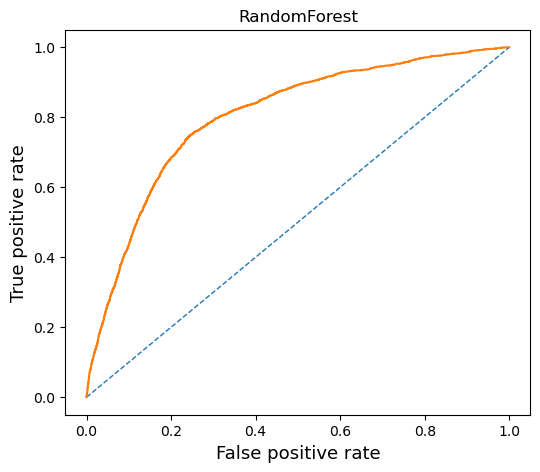

In [14]:
mse = mean_squared_error(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test, probs[:,1])
roc_auc = auc(false_pos_rate, true_pos_rate)

roc_data = pd.DataFrame({'X': false_pos_rate.tolist(), 'Y': true_pos_rate.tolist()})
roc_data.to_csv('./figs/plot_data/roc_curve_rf.csv', index=False)
    

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Mean squared error = ",mse)
print("Accuracy = ",acc)
print("ROC AUC score = ",roc_auc)

plt.figure(figsize = (6,5))
plt.plot([0,1], [0,1], '--', lw=1)
plt.plot(false_pos_rate, true_pos_rate)
plt.xlabel('False positive rate', fontsize=13)
plt.ylabel('True positive rate', fontsize=13)
plt.title('RandomForest')
plt.show()

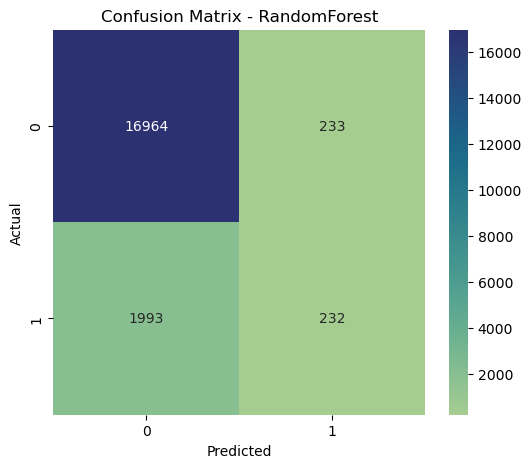

Confusion Matrix:
 [[16964   233]
 [ 1993   232]]


In [15]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(6, 5))

sns.heatmap(cm, annot=True, cmap='crest', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RandomForest')

plt.savefig('./figs/conf_mat_rf.png')
plt.show()

# Print confusion matrix and classification report for detailed metrics
print("Confusion Matrix:\n", cm)

### Using grid search to tune



#### First search: `max_depth`

In [ ]:
scoring_metric = 'recall'

In [ ]:
%%time
best_params_GS = {}

param_test_1 = {
    'max_depth': range(5, 31, 5)
}
gsearch_1 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=800, random_state = 42), 
 param_grid = param_test_1, scoring=scoring_metric,n_jobs=-1, cv=5)
gsearch_1.fit(X_train,y_train)

best_params_GS.update(gsearch_1.best_params_)
print("The best parameters are:", gsearch_1.best_params_)
print("Best", scoring_metric, "score = ",gsearch_1.best_score_)

The best parameters are: {'max_depth': 30}
Best recall score =  0.04561362446296425
CPU times: total: 57.5 s
Wall time: 3min 46s


#### Second search: `max_features`

In [ ]:
list_feat = [None, 1.0, 'sqrt', 'log2']

In [ ]:
%%time

param_test_2 = {'max_features': list_feat}

gsearch_2 = GridSearchCV(estimator = RandomForestClassifier(**best_params_GS, n_estimators = 800, random_state = 42), 
 param_grid = param_test_2, scoring=scoring_metric,n_jobs=-1, cv=5)
gsearch_2.fit(X_train,y_train)

best_params_GS.update(gsearch_2.best_params_)
print("The best parameters are:", gsearch_2.best_params_)
print("Best", scoring_metric, "score = ",gsearch_2.best_score_)

The best parameters are: {'max_features': None}
Best recall score =  0.10729289819505516
CPU times: total: 5min 57s
Wall time: 16min 24s


#### Third search: `criterion` and `bootstrap`

In [ ]:
%%time

param_test_3 = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'bootstrap': [True, False]
}

gsearch_3 = GridSearchCV(estimator = RandomForestClassifier(**best_params_GS, n_estimators = 1000,  random_state = 42), 
 param_grid = param_test_3, scoring='roc_auc',n_jobs=-1, cv=5)
gsearch_3.fit(X_train,y_train)

best_params_GS.update(gsearch_3.best_params_)
print("The best parameters are:", gsearch_3.best_params_)
print("Best", scoring_metric, "score = ",gsearch_3.best_score_)

The best parameters are: {'bootstrap': True, 'criterion': 'entropy'}
Best AUC score =  0.8185440258431227
CPU times: total: 2min 39s
Wall time: 14min 11s


In [ ]:
best_params = {'max_depth':30,
               'max_features': None,
               'criterion': 'entropy',
               'bootstrap': True}
#best_params_GS#best_params_RS